### Import

In [25]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import pandas as pd
import cv2
import os
import glob
import random

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.callbacks import ModelCheckpoint

from keras.applications.resnet import ResNet50

### Data Loading

In [6]:
train_folder = "C:/Users/truon/OneDrive/Desktop/DogvsCat/Train"
val_folder = "C:/Users/truon/OneDrive/Desktop/DogvsCat/Val"
test_folder = "C:/Users/truon/OneDrive/Desktop/DogvsCat/Test"

classes = sorted(os.listdir(train_folder))
n_classes = len(classes)

print("Class:", classes)
print("No. of Classes:", n_classes)

Class: ['cat', 'rabbit']
No. of Classes: 2


In [7]:
data = []

for folder in ["train", "test", "val"]:
    for class_name in classes:
        folder_path = eval(f"{folder}_folder")
        class_folder = f"{folder_path}/{class_name}"
        filepaths = glob.glob(f"{class_folder}/*.jpg")
        data.extend([[class_name, filepath, folder] for filepath in filepaths])

df = pd.DataFrame(data, columns=["labels", "filepaths", "dataset"])
df.to_csv("output.csv", index=False)
"""range_class = {"cat": 0, "rabbit": 1}
df['labels'] = df['labels'].map(range_class)"""
df.head()

,labels,filepaths,dataset
0,cat,C:/Users/truon/OneDrive/Desktop/DogvsCat/Train...,train
1,cat,C:/Users/truon/OneDrive/Desktop/DogvsCat/Train...,train
2,cat,C:/Users/truon/OneDrive/Desktop/DogvsCat/Train...,train
3,cat,C:/Users/truon/OneDrive/Desktop/DogvsCat/Train...,train
4,cat,C:/Users/truon/OneDrive/Desktop/DogvsCat/Train...,train


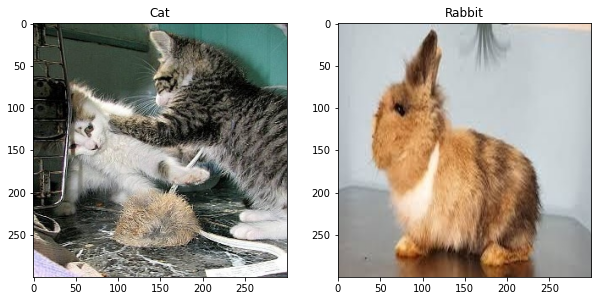

In [4]:
class_0_images = df[df["labels"] == "cat"]
class_1_images = df[df["labels"] == "rabbit"]

random_index_0 = random.randint(0, len(class_0_images)-1)
image_path_0 = class_0_images.iloc[random_index_0]["filepaths"]

random_index_1 = random.randint(0, len(class_1_images)-1)
image_path_1 = class_1_images.iloc[random_index_1]["filepaths"]

fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 10))
image_0 = plt.imread(image_path_0)
ax0.imshow(image_0)
ax0.set_title("Cat")

image_1 = plt.imread(image_path_1)
ax1.imshow(image_1)
ax1.set_title("Rabbit")
plt.show()

In [8]:
dataset = df.groupby('dataset')
train_df = dataset.get_group('train')
test_df = dataset.get_group('test')
val_df = dataset.get_group('val')
val_df.head()

,labels,filepaths,dataset
1615,cat,C:/Users/truon/OneDrive/Desktop/DogvsCat/Val/c...,val
1616,cat,C:/Users/truon/OneDrive/Desktop/DogvsCat/Val/c...,val
1617,cat,C:/Users/truon/OneDrive/Desktop/DogvsCat/Val/c...,val
1618,cat,C:/Users/truon/OneDrive/Desktop/DogvsCat/Val/c...,val
1619,cat,C:/Users/truon/OneDrive/Desktop/DogvsCat/Val/c...,val


In [9]:
img_size = (256, 256)
batch_size = 16

def _generator_train_(dataframe, img_size, batch_size, shuffle):
    _data_= ImageDataGenerator(rotation_range= 40,
                    width_shift_range= 0.2,
                    height_shift_range= 0.2,
                    shear_range= 0.2,
                    zoom_range= 0.2,
                    horizontal_flip=True,
                    fill_mode='nearest').flow_from_dataframe(dataframe,
                                            x_col = "filepaths",
                                            y_col = "labels",
                                            class_mode = "categorical",
                                            color_mode = "rgb",
                                            target_size = img_size,
                                            shuffle = shuffle,
                                            batch_size = batch_size)
    return _data_

def _generator_test_val_(dataframe, img_size, batch_size, shuffle):
    _data_= ImageDataGenerator().flow_from_dataframe(dataframe,
                                            x_col = "filepaths",
                                            y_col = "labels",
                                            class_mode = "categorical",
                                            color_mode = "rgb",
                                            target_size = img_size,
                                            shuffle = shuffle,
                                            batch_size = batch_size)
    return _data_

train_data = _generator_train_(train_df, img_size, batch_size, True)
test_data = _generator_test_val_(test_df, img_size, batch_size, False)
val_data = _generator_test_val_(val_df, img_size, batch_size, False)

Found 1600 validated image filenames belonging to 2 classes.
Found 15 validated image filenames belonging to 2 classes.
Found 414 validated image filenames belonging to 2 classes.


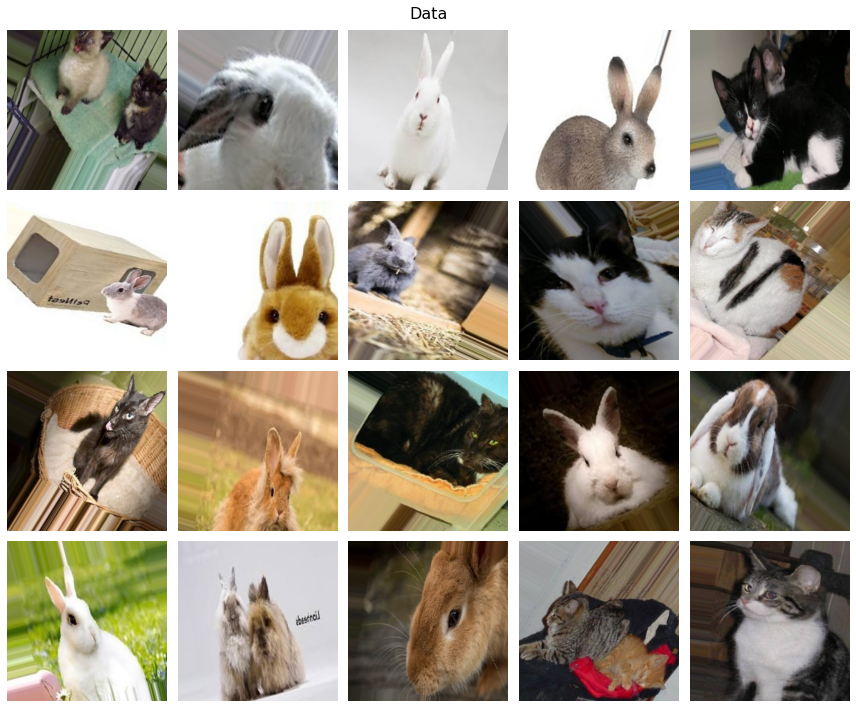

In [57]:
random_indices = random.sample(range(len(train_data)), 20)
fig, axes = plt.subplots(4, 5, figsize=(12, 10))

for i, ax in enumerate(axes.flatten()):
    image = train_data[random_indices[i]][0][0].astype('uint8')
    ax.imshow(image)
    ax.axis('off')

plt.suptitle('Data', fontsize=16)
plt.tight_layout()
plt.show()

### Build Model

In [42]:
class Model_Classifier:
    def __init__(self, base_conv, lr, n_epochs, checkpoint_, train_, val_):
        self.lr = lr
        self.n_epochs = n_epochs
        self.checkpoint_ = checkpoint_
        self.base_conv = base_conv
        self.data_train = train_
        self.data_val = val_
        self.base_conv.trainable = True
        self.x = self.base_conv.output
        self.x = BatchNormalization()(self.x)
        self.x = Dense(1024, activation = 'relu')(self.x)
        self.x = Dropout(0.25)(self.x)
        self.x = Dense(512, activation = 'relu')(self.x)
        self.x = Dropout(0.25)(self.x)
        self.x = Dense(256, activation = 'relu')(self.x)
        self.x = Dropout(0.25)(self.x)
        self.x = Dense(128, activation = 'relu')(self.x)
        self.x = Dropout(0.25)(self.x)
        self.outputs = Dense(2, activation= 'softmax')(self.x)
        self.model = Model(inputs = self.base_conv.input, outputs = self.outputs)

    def compile_model(self):
        self.model.compile(
            optimizer = Adam(learning_rate = self.lr),
            loss = "categorical_crossentropy",
            metrics=["accuracy"],
            run_eagerly=True
            )

    def fit(self):
        self.compile_model()
        self.model.fit(
                x = self.data_train,
                epochs = self.n_epochs,
                validation_data = self.data_val,
                callbacks = [self.checkpoint_])

    def summary(self):
        self.model.summary()

In [43]:
resnet50 = ResNet50(include_top= False,
                                weights= 'imagenet',
                                input_shape = (256, 256, 3),
                                pooling= 'max')

### Train Model

In [44]:
checkpoint = ModelCheckpoint("best_weight_model_resnet50.h5",
                                monitor = 'val_accuracy',
                                save_best_only = True,
                                mode = 'auto')

Classifier_ResNet50 = Model_Classifier(resnet50, lr = 0.001,
                                        n_epochs = 50,
                                        checkpoint_ = checkpoint,
                                        train_ = train_data,
                                        val_ = val_data)
Classifier_ResNet50.fit()

Epoch 1/50
100/100 [==============================] - 34s 322ms/step - loss: 0.8292 - accuracy: 0.6762 - val_loss: 605.4694 - val_accuracy: 0.5000
Epoch 2/50
100/100 [==============================] - 30s 300ms/step - loss: 0.7027 - accuracy: 0.6681 - val_loss: 149.9804 - val_accuracy: 0.5048
Epoch 3/50
100/100 [==============================] - 30s 302ms/step - loss: 0.5930 - accuracy: 0.7506 - val_loss: 0.6244 - val_accuracy: 0.6618
Epoch 4/50
100/100 [==============================] - 30s 300ms/step - loss: 0.4946 - accuracy: 0.7850 - val_loss: 0.5561 - val_accuracy: 0.6763
Epoch 5/50
100/100 [==============================] - 29s 292ms/step - loss: 0.4940 - accuracy: 0.7781 - val_loss: 3.0347 - val_accuracy: 0.5024
Epoch 6/50
100/100 [==============================] - 31s 303ms/step - loss: 0.5430 - accuracy: 0.7831 - val_loss: 0.5316 - val_accuracy: 0.7391
Epoch 7/50
100/100 [==============================] - 31s 305ms/step - loss: 0.4821 - accuracy: 0.7950 - val_loss: 0.5412 - va

### Test Model

In [11]:
def evaluate_model(model, test_data):
    results = model.evaluate(test_data)
    loss = results[0]
    accuracy = results[1]

    print("Loss:", round(loss, 4))
    print("Accuracy:",round( accuracy, 4))

In [12]:
model_resnet50 = tf.keras.models.load_model("C:/Users/truon/OneDrive/Desktop/DogvsCat/best_weight_model.h5")
print("model_resnet50")
evaluate_model(model_resnet50, test_data)

model_resnet50
1/1 [==============================] - 4s 4s/step - loss: 0.3040 - accuracy: 0.8000
Loss: 0.304
Accuracy: 0.8


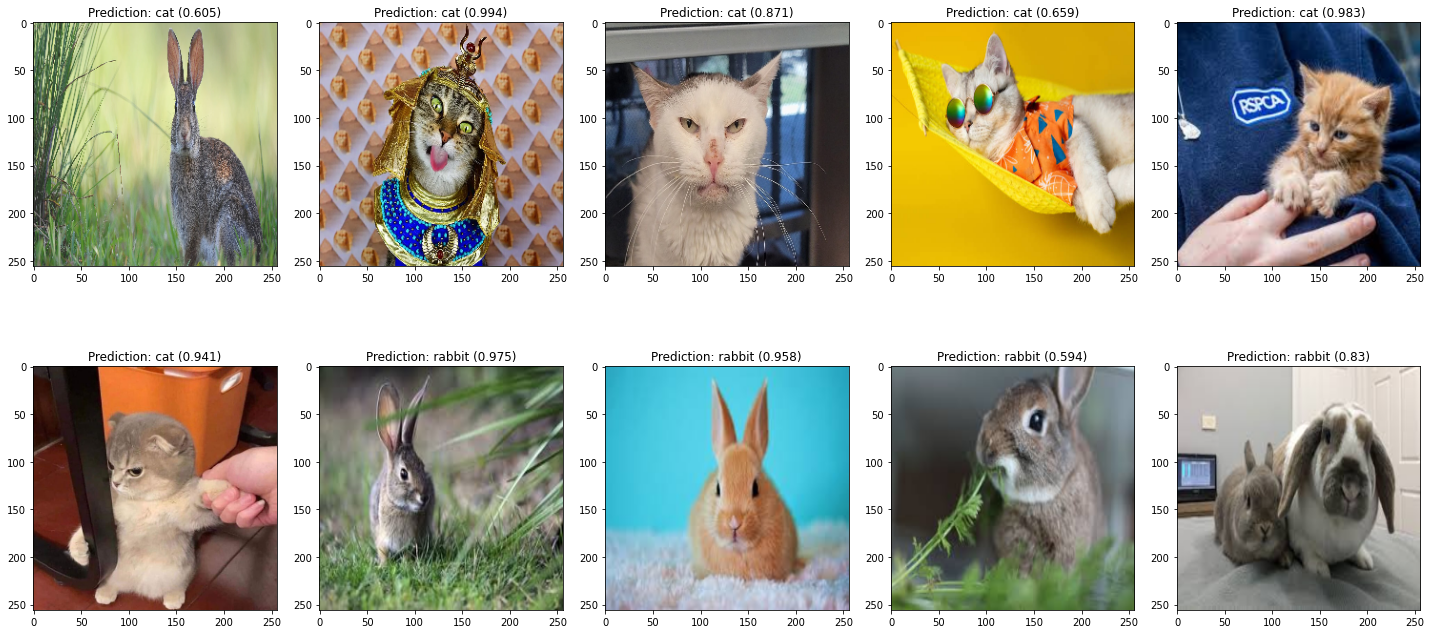

In [64]:
class_indices = list(train_data.class_indices.values())
class_names = list(train_data.class_indices.keys())

fig, axes = plt.subplots(2, 5, figsize=(20, 10))
folder_path = 'C:/Users/truon/OneDrive/Desktop/DogvsCat/Test_Nor'

for i, filename in enumerate(os.listdir(folder_path)):
    if filename.endswith('.jpg') or filename.endswith('.png') or filename.endswith('.webp'):
        image_path = os.path.join(folder_path, filename)
        img = np.array(cv2.resize(cv2.imread(image_path), (256, 256)))
        pred = model_resnet50.predict(img[None, :, :])[0]
        index = np.argmax(pred)
        index_ = round(np.max(pred), 3)

        ax = axes[i // 5, i % 5]
        ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        title = "Prediction: " + class_names[index] + " (" + str(index_) + ")"
        ax.set_title(title)

plt.tight_layout()
plt.show()